In [1]:
import matplotlib.pyplot as plt
import cv2
import OpenEXR
import Imath
import numpy as np
from pprint import pprint
import random
from tqdm import tqdm
import time
import os

In [2]:
test_org='/mnt/Velocity_Vault/Autofocus/Test'
train_org='/mnt/Velocity_Vault/Autofocus/Train/'


Get Train subfolders ( if needed reduce dataset size here)

In [3]:
import os

def get_subfolder_paths(path):
    if not os.path.isdir(path):
        raise ValueError(f"The provided path '{path}' is not a valid directory.")
    
    subfolders = [
        os.path.join(path, name) 
        for name in os.listdir(path) 
        if os.path.isdir(os.path.join(path, name))
    ]
    return subfolders

train_path=get_subfolder_paths(train_org)
test_path=[test_org]


# train_path=[train_path[0]]

pprint(train_path)

['/mnt/Velocity_Vault/Autofocus/Train/train1',
 '/mnt/Velocity_Vault/Autofocus/Train/train2',
 '/mnt/Velocity_Vault/Autofocus/Train/train3',
 '/mnt/Velocity_Vault/Autofocus/Train/train4',
 '/mnt/Velocity_Vault/Autofocus/Train/train5',
 '/mnt/Velocity_Vault/Autofocus/Train/train6',
 '/mnt/Velocity_Vault/Autofocus/Train/train7']


Get Picture locations

In [4]:
def get_frame_location(path, upto):
    if not os.path.isdir(path):
        raise ValueError(f"The provided path '{path}' is not a valid directory.")

    subfolders = []

    def find_subfolders(current_path, level):
        if level > upto:  # Stop recursion if the level exceeds 3
            return
        for item in os.listdir(current_path):
            item_path = os.path.join(current_path, item)
            if os.path.isdir(item_path):
                if level==upto:
                    subfolders.append(item_path)
                find_subfolders(item_path, level + 1)

    find_subfolders(path, 1)
    return subfolders

# pos -
# 0 - raw_left
# 1 - raw_right
# 2 - depth
# 3 - conf

def get_image_location(path,pos):
    
    suffix={
        0:"/raw_up_left_pd",
        1:"/raw_up_right_pd",
        2:"/merged_depth",
        3:"/merged_conf",
    }
    
    upto={
        0:1,
        1:1,
        2:1,
        3:1
    }
    
    raw_left=[]
    for p in path:
        raw_left+=get_frame_location(p+suffix[pos],upto[pos])
        
    return raw_left

train_image=[[] for _ in range(4)]

for i in range(4):
    train_image[i]=get_image_location(train_path,i)

test_image=[[] for _ in range(4)]

for i in range(4):
    test_image[i]=get_image_location(test_path,i)

def get_list_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_list_shape(lst[0]) if lst else [0]
    else:
        return []
    
pprint(get_list_shape(train_image))
pprint(get_list_shape(test_image))

[4, 355]
[4, 47]


In [5]:
def sleep_with_progress(seconds):
    print("Start Sleeping",seconds,"seconds")
    time.sleep(seconds)
    print("End Sleeping")

def check_image_connection(image_path):
    # Display the "Reconnect Drive" message
    
    print("Reconnect Drive")
    checking=True
    
    while checking:
        # Try reading the image
        if (not os.path.isfile(image_path)) or (not os.path.isdir('/mnt/Velocity_Vault')):
            time.sleep(10)
        else:
            print(image_path)
            checking=False
    print("Drive Connected")

def convert_range(value, old_min=0, old_max=65535, new_min=-1, new_max=1):
    # Linear interpolation formula
    return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min


def get_image_array(image_path,x,y,change_range=False):
    
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
    
    if image is None:
        check_image_connection(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    send=image[x:x+128,y:y+128]
    
    if change_range:
        send=convert_range(send)
        
    #print(image.shape)
    
    return send


def load_depth_image(image_path,x,y):
    # Load standard image format (e.g., PNG, JPG)
    depth_array = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if depth_array is None:
        check_image_connection(image_path)
        depth_array = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert to float32 for consistency
    depth_array = np.float32(depth_array)

    return depth_array[x:x+32, y:y+32]

def load_conf_image(exr_path, x,y,channel="R"):
    
    try:
        exr_file = OpenEXR.InputFile(exr_path)
    except Exception as e:
        check_image_connection(exr_path)
        exr_file = OpenEXR.InputFile(exr_path)
        
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)  
    channel_data = exr_file.channel(channel, pixel_type)
    np_array = np.frombuffer(channel_data, dtype=np.float32).reshape((height, width))
    
    return np_array[x:x+32, y:y+32]


def approx_depth(depth, conf):
    
    depth_values = depth.flatten()
    confidence_values = conf.flatten()

    # Compute the weighted average depth
    weighted_sum = np.sum(depth_values * confidence_values)
    total_confidence = np.sum(confidence_values)
    
    approximate_depth = weighted_sum / total_confidence

    return approximate_depth


def find_slice(desc_list, number):
    if not desc_list:
        raise ValueError("The list cannot be empty.")
    if not all(desc_list[i] >= desc_list[i + 1] for i in range(len(desc_list) - 1)):
        raise ValueError("The list must be in descending order.")
    
    closest_index = min(range(len(desc_list)), key=lambda i: abs(desc_list[i] - number))
    return closest_index


def predict_slice(depth):
    
    approx=depth/255.0

    max_val=3.9
    min_val=0.1

    metre=(max_val * min_val) / (max_val - (max_val - min_val) * approx)
    metre*=1000

    slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

    slice_focus=find_slice(slice_focal_length,metre)
    
    return slice_focus
    
def create_patches(n):
    
    def generate_positions(size, clear, countx,county):
        positions=[]
        pad=clear//2
        for i in range(countx):
            for j in range(county):
                positions.append([i*(size+clear)+pad,j*(size+clear)+pad])
        return positions
    
    positions=generate_positions(128,40,12,9)
    
    if n > len(positions):
        raise ValueError("n cannot be greater than the length of the list.")
    
    return random.sample(positions, n)

def transpose_list(input_list):
    np_array = np.array(input_list)
    transposed_array = np.transpose(np_array, (1, 2, 0))
    return transposed_array

def make_stack(left_loc,right_loc,depth_loc,conf_loc):
    
    slices=np.zeros((12,128, 128,98))
    truth=[0 for _ in range(12)]
    
    patch_pos=create_patches(12)
    
    for pos,patch in enumerate(patch_pos):
        
        x=patch[0]
        y=patch[1]
        
        frames=np.zeros((98, 128, 128))
        
        for i in range(49):
            left_frame=left_loc+"/"+str(i)+'/result_up_pd_left_center.png'
            right_frame=right_loc+"/"+str(i)+'/result_up_pd_right_center.png'

            frames[i*2]=get_image_array(left_frame,x,y,change_range=True)
            frames[i*2+1]=get_image_array(right_frame,x,y,change_range=True)
            
        # display_map(frames[0])
            
        slices[pos]=transpose_list(frames)
            
        depth_frame=depth_loc+'/result_merged_depth_center.png'
        conf_frame=conf_loc+'/result_merged_conf_center.exr'
        
        x//=4
        y//=4
        
        depth=load_depth_image(depth_frame,x,y)
        conf=load_conf_image(conf_frame,x,y)
        
        approx=approx_depth(depth,conf)
        focus=predict_slice(approx)
        
        truth[pos]=focus
        
        
    return slices,truth

In [6]:

memmap_path='/mnt/Velocity_Vault/Autofocus/Dataset_Storage/'
num_patches=12

train_dataset = np.memmap(memmap_path+"train_dataset", dtype=np.float64, mode='w+', shape=(num_patches*len(train_image[0]),128, 128,98))
train_truth = np.memmap(memmap_path+"train_truth", dtype=int, mode='w+', shape=(num_patches*len(train_image[0])))


test_dataset = np.memmap(memmap_path+"test_dataset", dtype=np.float64, mode='w+', shape=(num_patches*len(test_image[0]),128, 128,98))
test_truth = np.memmap(memmap_path+"test_truth", dtype=int, mode='w+', shape=(num_patches*len(test_image[0])))


In [7]:
print(train_dataset.shape)
print(train_truth.shape)
print(test_dataset.shape)
print(test_truth.shape)

(4260, 128, 128, 98)
(4260,)
(564, 128, 128, 98)
(564,)


In [8]:

def load_train_dataset():
    for i in tqdm(range(len(train_image[0]))):
        
        left_loc=train_image[0][i]
        right_loc=train_image[1][i]
        depth_loc=train_image[2][i]
        conf_loc=train_image[3][i]
        
        slices,truth=make_stack(left_loc,right_loc,depth_loc,conf_loc)
        
        for j in range(num_patches):
            train_dataset[num_patches*i+j]=slices[j]
            train_truth[num_patches*i+j]=truth[j]
                        
def load_test_dataset():
    for i in tqdm(range(len(test_image[0]))):
        
        left_loc=test_image[0][i]
        right_loc=test_image[1][i]
        depth_loc=test_image[2][i]
        conf_loc=test_image[3][i]
        
        slices,truth=make_stack(left_loc,right_loc,depth_loc,conf_loc)
        
        for j in range(num_patches):
            test_dataset[num_patches*i+j]=slices[j]
            test_truth[num_patches*i+j]=truth[j]

In [9]:
load_test_dataset()

pprint(test_dataset.shape)
pprint(test_truth.shape)


100%|██████████| 47/47 [36:14<00:00, 46.26s/it]

(564, 128, 128, 98)
(564,)


In [10]:
load_train_dataset()

pprint(train_dataset.shape)
pprint(train_truth.shape)

100%|██████████| 355/355 [4:40:24<00:00, 47.39s/it]  

(4260, 128, 128, 98)
(4260,)


In [11]:
train_truth_one_hot = np.memmap(memmap_path+"train_truth_one_hot", dtype=int, mode='w+', shape=(num_patches*len(train_image[0]),49))

train_truth_one_hot[np.arange(len(train_truth)),train_truth]=1

In [12]:
from pprint import pprint

pprint(train_truth.shape)
pprint(train_truth_one_hot.shape)

(4260,)
(4260, 49)


In [13]:
# memmap_path='/mnt/Velocity_Vault/Autofocus/Dataset_Storage/'
# num_patches=12
# import numpy as np
# from tqdm import tqdm

# train_dataset = np.memmap(memmap_path+"train_dataset", dtype=np.float64, mode='r', shape=(num_patches*355,128, 128,98))
# train_truth = np.memmap(memmap_path+"train_truth", dtype=int, mode='r', shape=(num_patches*355))

# ordered_train_dataset = np.memmap(memmap_path+"ordered_train_dataset", dtype=np.float64, mode='w+', shape=(num_patches*355,128, 128,98))
# ordered_train_truth = np.memmap(memmap_path+"ordered_train_truth", dtype=int, mode='w+', shape=(num_patches*355))

# sorted_indices = np.argsort(train_truth)
# print(sorted_indices.shape)

# for i in tqdm(range(len(sorted_indices))):
#     ordered_train_dataset[i] = train_dataset[sorted_indices[i]]
#     ordered_train_truth[i] = train_truth[sorted_indices[i]]
#     ordered_train_dataset.flush()
#     ordered_train_truth.flush()
    
    
# from pprint import pprint

# pprint(ordered_train_truth)

In [14]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_occurrences(numbers):
    # Count occurrences of each element
    occurrences = Counter(numbers)
    

    # Extract keys (unique numbers) and their corresponding values (counts)
    elements = list(occurrences.keys())
    counts = list(occurrences.values())
    print(np.mean(counts))

    # Plot a horizontal bar graph
    plt.figure(figsize=(8, 5))
    plt.barh(elements, counts, color="skyblue")
    plt.xlabel("Occurrences")
    plt.ylabel("Elements")
    plt.title("Occurrences of Elements in the List")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

86.93877551020408


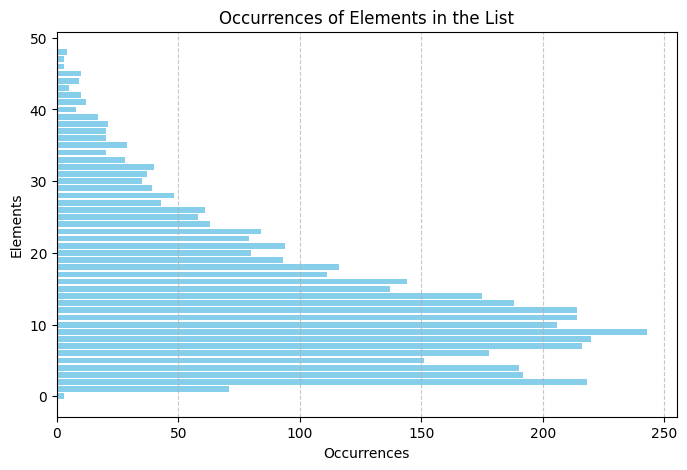

13.428571428571429


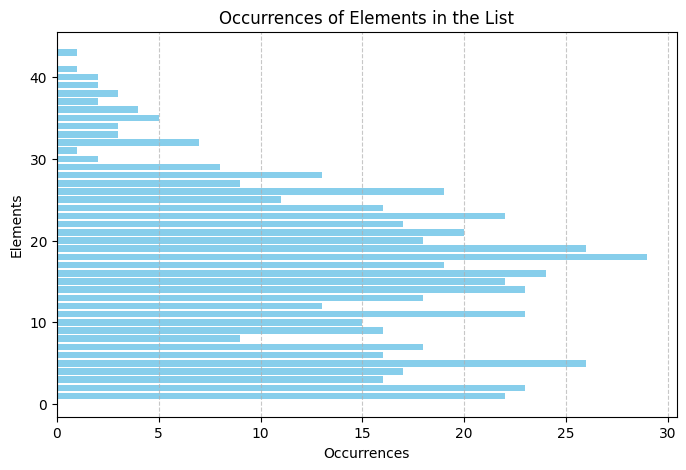

In [15]:


    
plot_occurrences(train_truth)
plot_occurrences(test_truth)

In [16]:
import numpy as np
from collections import defaultdict
import random
from tqdm import tqdm
import time

def sleep_for_seconds(n):
    """
    Pauses the execution of the program for n seconds.

    Args:
        n (int or float): Number of seconds to sleep. Can be a float for sub-second precision.

    Returns:
        None
    """
    print(f"Sleeping for {n} seconds...")
    time.sleep(n)
    print(f"Done sleeping for {n} seconds.")
    
def resample_memmap(train_dataset, train_truth, target_size, output_data_path, output_truth_path):
    """
    Resamples a memmap dataset (undersampling and oversampling) to a specific size.

    Args:
        train_dataset: memmap array containing dataset features.
        train_truth: memmap array containing ground truth labels.
        target_size: Total desired size for the resampled dataset.
        output_data_path: Path to save the resampled dataset memmap array.
        output_truth_path: Path to save the resampled ground truth memmap array.

    Returns:
        Resampled memmap arrays (data, truth).
    """
    # Count samples per class
    class_indices = defaultdict(list)
    for i, label in enumerate(train_truth):
        class_indices[label].append(i)
        
    
    
    num_classes = len(class_indices)
    samples_per_class = target_size // num_classes
    
    print(num_classes)
    print(samples_per_class)

    # Prepare resampled indices
    resampled_indices = []
    for label, indices in class_indices.items():
        if len(indices) > samples_per_class:  # Undersample
            resampled_indices.extend(random.sample(indices, samples_per_class))
        else:  # Oversample
            resampled_indices.extend(indices + random.choices(indices, k=samples_per_class - len(indices)))

    # Shuffle the resampled indices
    random.shuffle(resampled_indices)

    # Create new memmap arrays for resampled data and truth
    resampled_data = np.memmap(output_data_path, dtype=train_dataset.dtype, mode='w+',
                               shape=(target_size, *train_dataset.shape[1:]))
    resampled_truth = np.memmap(output_truth_path, dtype=train_truth.dtype, mode='w+', shape=(target_size,))

    # Copy data efficiently using resampled indices
    print(len(resampled_indices))
    for i, idx in tqdm(enumerate(resampled_indices)):
        if i%500==0:
            sleep_for_seconds(10)
        resampled_data[i] = train_dataset[idx]
        resampled_truth[i] = train_truth[idx]
        resampled_data.flush()
        resampled_truth.flush()
        
    return resampled_data, resampled_truth



# memmap_path='/mnt/Velocity_Vault/Autofocus/Dataset_Storage/'
# num_patches=12
# image_size=355

# train_dataset = np.memmap(memmap_path+"train_dataset", dtype=np.float64, mode='r', shape=(num_patches*image_size,128, 128,98))
# train_truth = np.memmap(memmap_path+"train_truth", dtype=int, mode='r', shape=(num_patches*image_size))


resampled_data, resampled_truth = resample_memmap(
    train_dataset,
    train_truth,
    target_size=3920,  # Desired size
    output_data_path=(memmap_path+'resampled_dataset'),
    output_truth_path=(memmap_path+'resampled_truth')
)


49
80
3920


0it [00:00, ?it/s]

Sleeping for 10 seconds...
Done sleeping for 10 seconds.


500it [00:59, 14.99it/s]

Sleeping for 10 seconds...


502it [01:09,  1.44s/it]

Done sleeping for 10 seconds.


1000it [01:54, 14.02it/s]

Sleeping for 10 seconds...
Done sleeping for 10 seconds.


1498it [02:56, 11.96it/s]

Sleeping for 10 seconds...


1501it [03:06,  1.30s/it]

Done sleeping for 10 seconds.


1999it [03:47,  9.49it/s]

Sleeping for 10 seconds...


2003it [03:58,  1.12s/it]

Done sleeping for 10 seconds.


2498it [04:45, 14.95it/s]

Sleeping for 10 seconds...


2501it [04:56,  1.26s/it]

Done sleeping for 10 seconds.


3000it [06:04,  1.46it/s]

Sleeping for 10 seconds...
Done sleeping for 10 seconds.


3499it [07:18,  8.87it/s]

Sleeping for 10 seconds...


3501it [07:28,  1.60s/it]

Done sleeping for 10 seconds.


3920it [08:24,  7.78it/s]


In [17]:
resampled_truth_one_hot = np.memmap(memmap_path+"resampled_truth_one_hot", dtype=int, mode='w+', shape=(3920,49))

resampled_truth_one_hot[np.arange(len(resampled_truth)),resampled_truth]=1
print(resampled_truth_one_hot.shape)

(3920, 49)


In [18]:
print(resampled_data.shape)

(3920, 128, 128, 98)


80.0


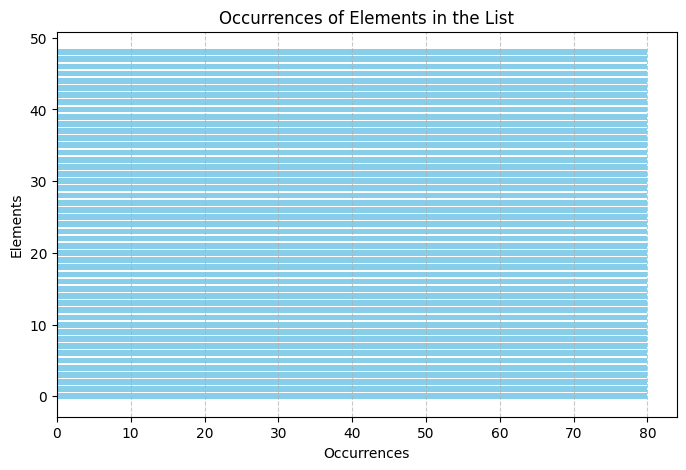

In [19]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_occurrences(numbers):
    # Count occurrences of each element
    occurrences = Counter(numbers)
    

    # Extract keys (unique numbers) and their corresponding values (counts)
    elements = list(occurrences.keys())
    counts = list(occurrences.values())
    print(np.mean(counts))

    # Plot a horizontal bar graph
    plt.figure(figsize=(8, 5))
    plt.barh(elements, counts, color="skyblue")
    plt.xlabel("Occurrences")
    plt.ylabel("Elements")
    plt.title("Occurrences of Elements in the List")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()
plot_occurrences(resampled_truth)